# 1. Introdução
 
Nesse NOTEBOOK encontra-se o código utilizado para aplicar a técnica de *Transfer Learning* com objetivo de aproveitar a capacidade de extração de features de animais da rede MobileNet somada a uma nova camada *fully connected* para classificação de gatos específicos de uma casa.

# 2. Parâmetros e Caminho das Imagens


In [46]:
classes = ["NENHUM", "HELENO", "PITUTA", "REGINALDO"]

#base_path = r"/Users/gsbezerra/source/junior/junior-homecat-training/results"
base_path = r"D:\source\\junior\\junior-homecat-training\\results"

EPOCHS = 40

BATCH_SIZE = 100

DIM = 96


# 3. Preparação dos Dados

# 3.1. Carga do Dataset


In [2]:
import cv2

def load_image(image_path):

    image = cv2.imread(image_path)
    image = cv2.resize(image, (DIM, DIM))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image


In [3]:
import os
import numpy as np


def load_dataset(base_path, classes):

    data = []
    labels = []

    os.chdir(base_path)


    for i in range(len(classes)):
        path = base_path+"/"+classes[i]

        j = 0
        with os.scandir(path) as files:

            for file in files:

                try:

                    image = load_image(file.path)

                    if image.shape[0] >= DIM:
                        data.append(image)
                        labels.append(i)
                        
                except:
                    pass

    data = np.array(data, dtype="float32") / 255.0
    labels = np.array(labels)

    return data, labels

In [5]:

data, labels = load_dataset(base_path, classes)

print(data.shape)
print(labels.shape)

(10453, 96, 96, 3)
(10453,)


# 3.2. Categorização

In [47]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

train_features, validation_features, train_labels, validation_labels = train_test_split(data, labels, test_size=0.2, random_state=0)

print('# of training images:', train_features.shape[0])
print('# of cross-validation images:', validation_features.shape[0])

X_train, y_train = train_features, train_labels
X_validation, y_validation = validation_features, validation_labels


# of training images: 8362
# of cross-validation images: 2091


# 3.3. Data Augmentation

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=10,  
    zoom_range=0.1,  
    width_shift_range=0.1,  
    height_shift_range=0.1,  
    horizontal_flip=True,  
    vertical_flip=False, 
)  

train_generator = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
validation_generator = ImageDataGenerator().flow(X_validation, y_validation, batch_size=BATCH_SIZE)


# 4. Modelagem

# 4.1. Modelo Base

In [48]:
from tensorflow import keras

base_model = keras.applications.MobileNet(
    weights='imagenet',
    input_shape=(DIM, DIM, 3),
    alpha=0.25,
    include_top=False
    )

base_model.trainable = False

base_model.summary()
    

Model: "mobilenet_0.25_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 48, 48, 8)         216       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 48, 48, 8)        32        
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 48, 48, 8)         0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 48, 48, 8)        72        
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 48, 48, 8)        32        
 ation)                                         

# 4.2. Classificacor Específico

In [49]:
import tensorflow as tf

base_model.trainable = False

last_layer = base_model.get_layer('conv_pw_10_relu')

#x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu')(last_layer.output)
x = tf.keras.layers.Reshape((-1, last_layer.output.shape[3]))(last_layer.output)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(units=len(classes), activation='softmax')(x)

model = tf.keras.Model(base_model.input, x)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

model.summary()


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 48, 48, 8)         216       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 48, 48, 8)        32        
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 48, 48, 8)         0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 48, 48, 8)        72        
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 48, 48, 8)        32        
 ation)                                                    

# 5. Treinamento

In [50]:
import tensorflow

steps_per_epoch = X_train.shape[0] // BATCH_SIZE
validation_steps = X_validation.shape[0] // BATCH_SIZE

history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
          validation_data=validation_generator, validation_steps=validation_steps,
          shuffle=True)

Epoch 1/40
83/83 [==============================] - 19s 220ms/step - loss: 0.8056 - accuracy: 0.6876 - val_loss: 0.2058 - val_accuracy: 0.9425
Epoch 2/40
83/83 [==============================] - 17s 207ms/step - loss: 0.2478 - accuracy: 0.9166 - val_loss: 0.1361 - val_accuracy: 0.9590
Epoch 3/40
83/83 [==============================] - 17s 205ms/step - loss: 0.1675 - accuracy: 0.9466 - val_loss: 0.0822 - val_accuracy: 0.9765
Epoch 4/40
83/83 [==============================] - 17s 204ms/step - loss: 0.1266 - accuracy: 0.9620 - val_loss: 0.0719 - val_accuracy: 0.9805
Epoch 5/40
83/83 [==============================] - 17s 204ms/step - loss: 0.1076 - accuracy: 0.9653 - val_loss: 0.0612 - val_accuracy: 0.9835
Epoch 6/40
83/83 [==============================] - 17s 204ms/step - loss: 0.0942 - accuracy: 0.9706 - val_loss: 0.0534 - val_accuracy: 0.9855
Epoch 7/40
83/83 [==============================] - 17s 203ms/step - loss: 0.0858 - accuracy: 0.9736 - val_loss: 0.0526 - val_accuracy: 0.9835

# 5.1. Desempenho

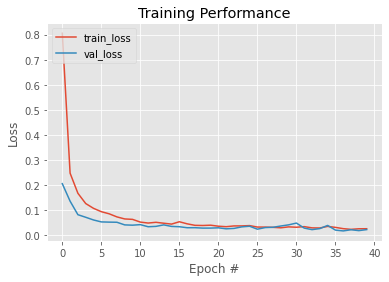

In [51]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")

plt.title("Training Performance")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper left")

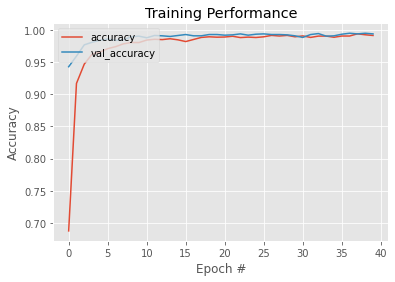

In [53]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), history.history["accuracy"], label="accuracy")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")

plt.title("Training Performance")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")

# 5.2. Nota Final

In [54]:
print("Evaluate on test data")
model.evaluate(X_validation, y_validation, batch_size=BATCH_SIZE)

Evaluate on test data
21/21 [==============================] - 1s 61ms/step - loss: 0.0223 - accuracy: 0.9938


[0.022344494238495827, 0.9937828779220581]

# 6. Fine Tuning

In [55]:

base_model.trainable = True

model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.000045),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=int(EPOCHS/2),
          validation_data=validation_generator, validation_steps=validation_steps,
          shuffle=True)

Epoch 1/20
83/83 [==============================] - 27s 306ms/step - loss: 0.0964 - accuracy: 0.9687 - val_loss: 0.0321 - val_accuracy: 0.9910
Epoch 2/20
83/83 [==============================] - 25s 295ms/step - loss: 0.0395 - accuracy: 0.9872 - val_loss: 0.0275 - val_accuracy: 0.9915
Epoch 3/20
83/83 [==============================] - 25s 298ms/step - loss: 0.0383 - accuracy: 0.9864 - val_loss: 0.0183 - val_accuracy: 0.9945
Epoch 4/20
83/83 [==============================] - 28s 339ms/step - loss: 0.0279 - accuracy: 0.9909 - val_loss: 0.0162 - val_accuracy: 0.9965
Epoch 5/20
83/83 [==============================] - 26s 310ms/step - loss: 0.0211 - accuracy: 0.9935 - val_loss: 0.0126 - val_accuracy: 0.9970
Epoch 6/20
83/83 [==============================] - 25s 300ms/step - loss: 0.0239 - accuracy: 0.9920 - val_loss: 0.0147 - val_accuracy: 0.9965
Epoch 7/20
83/83 [==============================] - 25s 297ms/step - loss: 0.0243 - accuracy: 0.9916 - val_loss: 0.0140 - val_accuracy: 0.9965

# 6.1. Desempenho

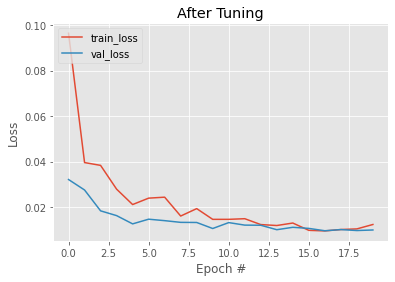

In [56]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure()
N = int(EPOCHS/2)
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")

plt.title("After Tuning")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper left")

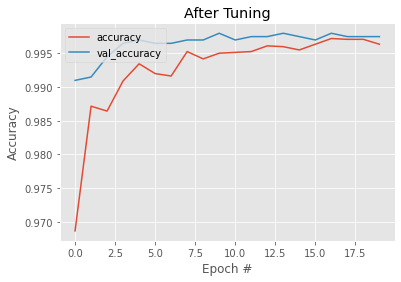

In [57]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure()
N = int(EPOCHS/2)
plt.plot(np.arange(0, N), history.history["accuracy"], label="accuracy")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")

plt.title("After Tuning")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")

# 6.2. Nota Final

In [58]:
print("Evaluate on test data")
_, model_accuracy = model.evaluate(X_validation, y_validation, batch_size=BATCH_SIZE)

Evaluate on test data
21/21 [==============================] - 1s 58ms/step - loss: 0.0096 - accuracy: 0.9976


# 7. Conversão

# 7.1. Modelo Final Sem Conversão

Para uso em testes posteriores.

In [59]:
tf.keras.models.save_model(
    model, base_path+"/home-cat-model-2", overwrite=True, include_optimizer=True, save_format=None,
    signatures=None, options=None
)


INFO:tensorflow:Assets written to: D:\source\\junior\\junior-homecat-training\\results/home-cat-model-2\assets


INFO:tensorflow:Assets written to: D:\source\\junior\\junior-homecat-training\\results/home-cat-model-2\assets


# 7.2. Método Auxiliar

In [60]:
def representative_dataset_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(data).batch(1).take(BATCH_SIZE):
    
    yield [input_value]

# 7.3. Quantização e Persistência

In [62]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.target_spec.supported_types = [tf.int8]

converter.inference_input_type = tf.int8 
converter.inference_output_type = tf.int8

tflite_quant_model = converter.convert()

open(base_path+'/home-cat-model-2.tflite', "wb").write(tflite_quant_model)

INFO:tensorflow:Assets written to: C:\Users\gleis\AppData\Local\Temp\tmpuqn5q4ws\assets


INFO:tensorflow:Assets written to: C:\Users\gleis\AppData\Local\Temp\tmpuqn5q4ws\assets
c:\Users\gleis\.conda\envs\ct213\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


166280

# 7.4. Avaliação do Modelo Convertido

In [63]:
import numpy as np

def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for i, test_image in enumerate(data):
    if i % 1000 == 0:
      print('Evaluated on {n} results so far.'.format(n=i))

    test_image = np.array(test_image*255-128, dtype="int8")
    test_image = test_image.reshape(1,DIM,DIM,3)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  print('\n')
  # Compare prediction results with ground truth labels to calculate accuracy.
  prediction_digits = np.array(prediction_digits)
  accuracy = (prediction_digits == labels).mean()
  return accuracy

In [64]:
interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
interpreter.allocate_tensors()

test_accuracy = evaluate_model(interpreter)

print('Quant TFLite test_accuracy:', test_accuracy)

Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.
Evaluated on 9000 results so far.
Evaluated on 10000 results so far.


Quant TFLite test_accuracy: 0.998947670525208
